In [ ]:
import csv
import platform
import shutil
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import decomposition, metrics, model_selection, naive_bayes, pipeline
from sklearn.preprocessing import StandardScaler
import os
from os.path import join
import cv2

from sklearn import preprocessing
import seaborn as sns



def group_accuracy(df_test, preds):
        nb_gr = 3
        nb_class = 3
  
        gr = np.zeros((nb_class, nb_gr))
        total = gr.copy()

        for i in range(len(preds)):
            grp = df_test.Style[i]
            cl = df_test.Label[i]
            #cl = single_super_data[prefix+'_labels'][i]
            gr[grp, cl] += df_test.Label[i] == preds[i]
            total[grp, cl] += 1

        print(total)
        
        for i in range(len(gr)):
            for n in range(len(gr[0])):
                gr[i,n] = gr[i,n]/total[i,n]

        idx = [f'bin {i}' for i in range(nb_gr)]
        col = [f'class {i}' for i in range(nb_class)]
        df = pd.DataFrame(gr,
                 index=idx,
                 columns=col)

        return df



def plot_group_confusion_matrix(cm, title):
        from matplotlib.patches import Rectangle

        cm = cm.round(2)
        figsize = (10,8)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()

        sns.heatmap(cm, annot=True, fmt='g', ax=ax, vmin=0, vmax=1, annot_kws={"size": 20});  #annot=True to annotate cells, ftm='g' to disable scientific notation
        
        
        ax.collections[0].colorbar.ax.tick_params(labelsize=16)
        
        # labels, title and ticks
        ax.set_title(title, fontsize=25)
        ax.set_xlabel('Class label Y ', fontsize=20)
        ax.set_ylabel('Spurious feature bin Z', fontsize=20)

        c = cm.to_numpy()
        m = np.amin(c)
        indices = []
        for i in range(cm.shape[0]):
            for n in range(cm.shape[1]):
                if c[i,n] == m:
                    indices.append((n,i))
        for ind in indices:
            ax.add_patch(Rectangle(ind,1,1, fill=False, edgecolor='blue', lw=3))

        idx = cm.index
        col = cm.columns

        ax.xaxis.set_ticklabels(col, fontsize=16)
        ax.yaxis.set_ticklabels(idx, fontsize=16)
        
        plt.show()


def evaluate_dataset(df_train, df_test, stylized_dataset, title = "Group Accuracy"):

    df_train = df_train.sample(frac = 1) #shuffle data
    df_test = df_test.reset_index(drop=True).copy()
    xs = {}
    ys = {}
    
    xs["train"] = [cv2.imread(join(stylized_dataset[style], filename)) for (filename, style) in zip(df_train.FILE_NAME, df_train.Style)]

    xs["train"] = [resize(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) for img in xs["train"]]

    xs["test-lab"] = [cv2.imread(join(stylized_dataset[style], filename)) for (filename, style) in zip(df_test.FILE_NAME, df_test.Style)]
    xs["test-lab"] = [resize(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) for img in xs["test-lab"]]

    ys["train"] = df_train.Label.to_numpy()
    ys["test-lab"] = df_test.Label.to_numpy()


    print(np.shape(xs["train"]), np.shape(ys["train"]))
    print(np.shape(xs["test-lab"]), np.shape(ys["test-lab"]))

    """# Visualize dataset sample"""

    NUM_TO_SHOW = 6

    fig, axs_ = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.3)
    axs = axs_.flatten()

    for i in range(NUM_TO_SHOW):
        img = xs["train"][i]
        label = ys["train"][i]
        axs[i].set_title(f"Example of {label}")
        axs[i].imshow(img)

    plt.show()

    """# Create Dataset"""

    import torch
    from torch.utils.data import Dataset
    from torch.utils.data import DataLoader
    import torch.optim as optim
    from torchvision import models, transforms
    import torch.nn as nn
    import os
    import shutil

    #In Pytorch usually need a Dataset class, quit easy to understand it just store the data
    class CustomImageDataset(Dataset):
        def __init__(self, images, labels, transform=None):
            self.img_labels = labels
            self.images = images
            self.transform = transform

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            trsfm  = transforms.Compose([
                transforms.ToTensor(),
            ])
            
            img = self.images[idx].astype(np.uint8)
            img = trsfm(img)
            label = self.img_labels[idx]
            if self.transform:
                img = self.transform(img)
            return img, label

    """# Create Dataloader

    Combines a dataset and a sampler, and provides an iterable over the given dataset.
    """

    train_loader = DataLoader(CustomImageDataset(xs["train"],ys["train"]), batch_size=5, shuffle=False)
    valid_loader = DataLoader(CustomImageDataset(xs["test-lab"],ys["test-lab"]), batch_size=5, shuffle=False)

    """# Fix the environment
    To make sure the model is deterministic and wont vary from one execution to another
    """

    SEED = 1234
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)

    """# Prepare GPU"""

    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print("GPU detected")
    else:
        device = torch.device('cpu')
        print("WARNING : No GPU detected")

    """# Model

    """

    featureExtraction = True #We train only the last layer, previous layer is used for feature extraction
    pretained = True # We use a pretrained model
    #If pretrained == False then featureExtraction should be false too, there is no point to do feature extr. without pretraining
    num_classes = len(np.unique(ys['train'])) #How many classes we have

    torch.cuda.empty_cache()

    '''
    model = models.resnet18(pretrained=pretained) #load pre-trained model
    if featureExtraction: 
        for param in model.parameters():
            param.requires_grad = False #We freeze all the layer
            
    num_ftrs = model.fc.in_features 
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    model.fc = nn.Linear(num_ftrs, num_classes) #modify the last layer according to number of categories we have
    model = model.to(device)
    '''
    model = models.alexnet(pretrained=pretained)

    if featureExtraction: 
        for param in model.parameters():
            param.requires_grad = False #We freeze all the layer

    num_ftrs = model.classifier[6].in_features
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    model.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    model = model.to(device)

    """# Training"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(trainable_params, lr=0.01, momentum=0.9)

    len(train_loader.dataset)

    class Trainer:
        '''Class to train our model'''
        def __init__(self, model, criterion, optimizer, train_loader, valid_loader, epochs = 10, verbose = True, save = True):
            self.model = model
            self.criterion = criterion
            self.optimizer = optimizer
            self.train_loader = train_loader
            self.valid_loader = valid_loader
            self.epochs = epochs
            self.verbose = verbose
            self.best_valid = 0
            self.save = save
        
        def valid_epoch(self):
            """One epoch of validation -- here Validation == Testing sicne we don't have validation set"""
            self.model.eval()
            nb_images = len(self.valid_loader.dataset)
            with torch.no_grad():
                running_loss = 0.0
                correct = 0
                for i, data in enumerate(self.valid_loader, 0): #iteration through batch 
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels) #Compute the loss
                    
                    pred = torch.argmax(outputs.cpu(), dim=1) #get the class predictions
                    correct += torch.sum(pred == labels.cpu()).item() #count correct answers
                    running_loss += loss.item()
                accu = correct/nb_images #compute accuracy
                if self.verbose :
                    print(f'Validation : Loss {running_loss/len(self.valid_loader):.3f} Accuracy {accu:.3f}')
                   
                if(accu - self.best_valid > 0.0025 and self.save): #we save best model on validation
                    self.best_valid = max(self.best_valid, accu)
                    self.save_checkpoint()
                    

        def train_epoch(self):
            '''One epoch of training'''
            self.model.train()
            nb_images = len(self.train_loader.dataset)
            running_loss = 0.0
            correct = 0
            cmpt = 0
            for i, data in enumerate(self.train_loader, 0): #iteration through batch 
                
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                pred = torch.argmax(outputs.cpu(), dim=1) #get the class predictions
                correct += torch.sum(pred == labels.cpu()).item() #count correct answers
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
            if self.verbose :
                print(f'Train : Loss {running_loss/len(self.train_loader):.3f} Accuracy {correct/nb_images:.3f}')
            
        def train(self):
            #iterate over the epochs
            for epoch in range(self.epochs):
                if self.verbose :
                    print(f"Epoch {epoch} : ")
                self.train_epoch()
                self.valid_epoch()
        
        def save_checkpoint(self):
            #save model
            if self.verbose:
                print("Saving model ...")
            torch.save(model, 'checkpoint-best-epoch.pth')
            
        def getModel(self):
            return self.model
        
        def setModel(self,model):
            self.model = model

    class utils:
        def load_best_model(model):
            #load a saved model
            model = torch.load('checkpoint-best-epoch.pth')
            model.eval()
            return model

        def predict(model, dataloader, device):
            #Make prediction over a dataloader
            model.to('cpu')
            all_preds = torch.tensor([])
            for batch in dataloader:
                inputs, labels = batch
                inputs, labels = inputs, labels
                outputs = model(inputs)
                
                outputs = model(inputs) 
                preds = torch.argmax(outputs.cpu(), dim=1) # get preds
                all_preds = torch.cat((all_preds, preds), dim=0) # join along existing axis
            return all_preds

    trainer = Trainer(model, criterion, optimizer, train_loader, valid_loader) #create trainer
    trainer.train() #train

    """# confusion matrix"""

    model = utils.load_best_model(model) #load
    pred = utils.predict(model, valid_loader, device) #pred over valid_lab
    pred = np.array(pred.tolist(),dtype = int)

    true_pred = valid_loader.dataset.img_labels #get the true labels

    data_set = "valid-lab"

    cm = metrics.confusion_matrix(true_pred,pred) #compute confusion matrix
    plt.imshow(cm, cmap='binary')

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
    cm_display.plot()
    plt.show()

    model = utils.load_best_model(model) #load model

    pred = utils.predict(model, valid_loader, device) #predict over valid_loader


    cm = group_accuracy(df_test, pred)

    plot_group_confusion_matrix(cm, title)

    return (np.array(pred) == np.array(ys['test-lab'])).sum()/len(pred)

In [ ]:
def resize(img):
  return cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)

# Create task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = "/content/drive/MyDrive/biased_experiment"
os.path.exists(root)

True

In [ ]:
df = pd.read_csv(join(root, "labels.csv"))

df = df[df.CATEGORY.isin(['snow boarding', 'horse racing', 'pole vault'])]

le = preprocessing.LabelEncoder()
le.fit(df.CATEGORY)
y = le.transform(df.CATEGORY)
df.loc[:, "Label"] = y

df_train = df.groupby("CATEGORY").sample(frac = 0.5)
df_test = df[~df.FILE_NAME.isin(df_train.FILE_NAME)]

### Biased train

In [ ]:
df = df_train.copy()

In [ ]:
over_rep = list(df.groupby('CATEGORY').sample(frac = 0.9).FILE_NAME)
under_rep1 = list(df[~df.FILE_NAME.isin(over_rep)].groupby('CATEGORY').sample(frac = 0.5).FILE_NAME)
under_rep2 = list(df[~df.FILE_NAME.isin(list(over_rep) + list(under_rep1))].FILE_NAME)

In [ ]:
for filename in df.FILE_NAME:
  if filename in over_rep and (filename in under_rep1 or filename in under_rep2):
    print("Error")

In [ ]:
df.loc[:, "Style"] = -1
for i in df.index:
  if df.loc[i, "FILE_NAME"] in over_rep:
    df.loc[i, "Style"] = df.loc[i, "Label"]
  elif df.loc[i, "FILE_NAME"] in under_rep1:
    df.loc[i, "Style"] = (df.loc[i, "Label"] + 1)%3
  else:
    df.loc[i, "Style"] = (df.loc[i, "Label"] + 2)%3

In [ ]:
df_biased_train = df.copy()



# Balanced train set



In [ ]:
df = df_train.copy()

In [ ]:
over_rep = list(df.groupby('CATEGORY').sample(frac = 1/3).FILE_NAME)
under_rep1 = list(df[~df.FILE_NAME.isin(over_rep)].groupby('CATEGORY').sample(frac = 0.5).FILE_NAME)
under_rep2 = list(df[~df.FILE_NAME.isin(list(over_rep) + list(under_rep1))].FILE_NAME)

In [ ]:
df.loc[:, "Style"] = -1
for i in df.index:
  if df.loc[i, "FILE_NAME"] in over_rep:
    df.loc[i, "Style"] = df.loc[i, "Label"]
  elif df.loc[i, "FILE_NAME"] in under_rep1:
    df.loc[i, "Style"] = (df.loc[i, "Label"] + 1)%3
  else:
    df.loc[i, "Style"] = (df.loc[i, "Label"] + 2)%3

In [ ]:
df_balanced_train = df.copy()

# Balanced Test Set

In [ ]:
df = df_test.copy()

In [ ]:
over_rep = list(df.groupby('CATEGORY').sample(frac = 1/3).FILE_NAME)
under_rep1 = list(df[~df.FILE_NAME.isin(over_rep)].groupby('CATEGORY').sample(frac = 0.5).FILE_NAME)
under_rep2 = list(df[~df.FILE_NAME.isin(list(over_rep) + list(under_rep1))].FILE_NAME)

In [ ]:
df.loc[:, "Style"] = -1
for i in df.index:
  if df.loc[i, "FILE_NAME"] in over_rep:
    df.loc[i, "Style"] = df.loc[i, "Label"]
  elif df.loc[i, "FILE_NAME"] in under_rep1:
    df.loc[i, "Style"] = (df.loc[i, "Label"] + 1)%3
  else:
    df.loc[i, "Style"] = (df.loc[i, "Label"] + 2)%3

In [ ]:
df_balanced_test = df.copy()

In [ ]:
stylized_dataset = ['/content/drive/MyDrive/biased_experiment/R0',
 '/content/drive/MyDrive/biased_experiment/R1',
 '/content/drive/MyDrive/biased_experiment/R2']

# Run Experiments

(60, 128, 128, 3) (60,)
(60, 128, 128, 3) (60,)


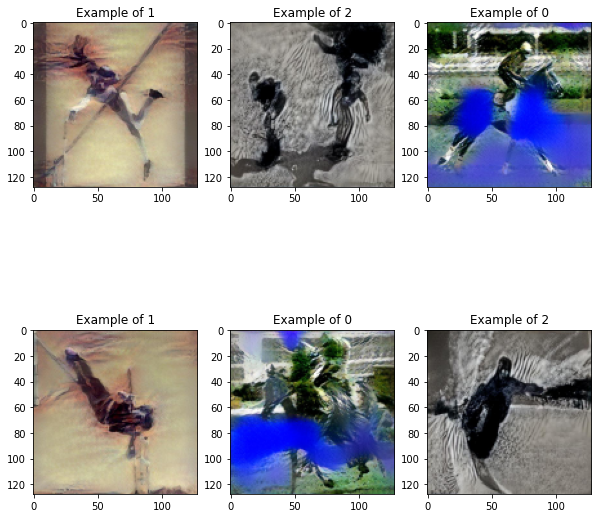

GPU detected


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 : 
Train : Loss 5.406 Accuracy 0.733
Validation : Loss 30.482 Accuracy 0.383
Saving model ...
Epoch 1 : 
Train : Loss 2.826 Accuracy 0.917
Validation : Loss 43.324 Accuracy 0.417
Saving model ...
Epoch 2 : 
Train : Loss 4.728 Accuracy 0.900
Validation : Loss 46.461 Accuracy 0.350
Epoch 3 : 
Train : Loss 3.095 Accuracy 0.900
Validation : Loss 37.585 Accuracy 0.367
Epoch 4 : 
Train : Loss 2.034 Accuracy 0.900
Validation : Loss 47.844 Accuracy 0.433
Saving model ...
Epoch 5 : 
Train : Loss 1.344 Accuracy 0.950
Validation : Loss 49.578 Accuracy 0.417
Epoch 6 : 
Train : Loss 0.479 Accuracy 0.967
Validation : Loss 50.700 Accuracy 0.383
Epoch 7 : 
Train : Loss 2.378 Accuracy 0.967
Validation : Loss 48.111 Accuracy 0.417
Epoch 8 : 
Train : Loss 1.496 Accuracy 0.950
Validation : Loss 57.764 Accuracy 0.433
Epoch 9 : 
Train : Loss 4.220 Accuracy 0.883
Validation : Loss 75.299 Accuracy 0.433


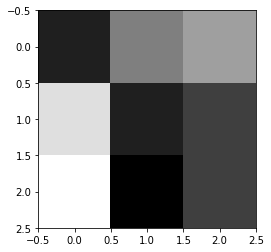

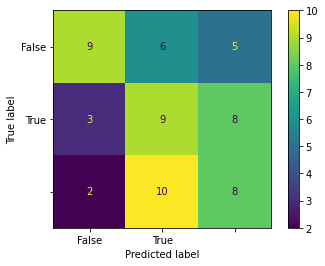

[[7. 7. 6.]
 [6. 7. 7.]
 [7. 6. 7.]]


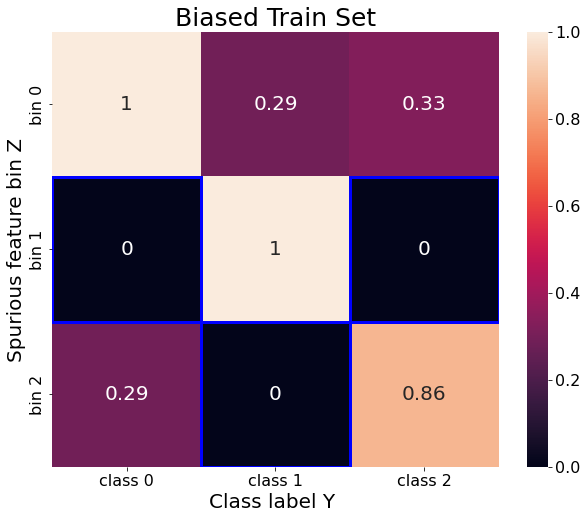

0.43333333333333335

In [ ]:
evaluate_dataset(df_biased_train, df_balanced_test, stylized_dataset, title = "Biased Train Set")

(60, 128, 128, 3) (60,)
(60, 128, 128, 3) (60,)


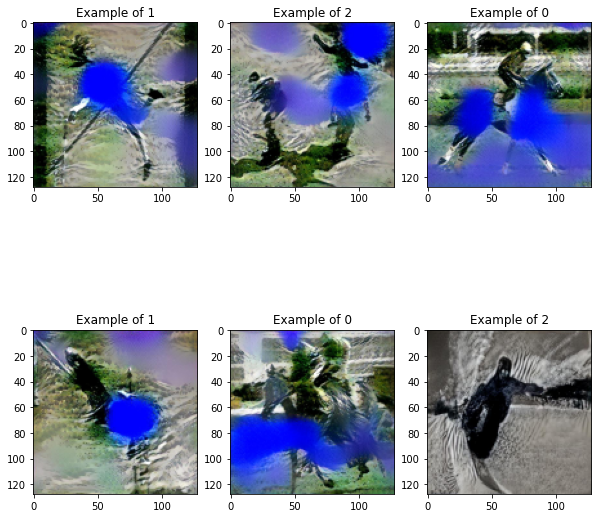

GPU detected


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 : 
Train : Loss 17.211 Accuracy 0.333
Validation : Loss 33.616 Accuracy 0.467
Saving model ...
Epoch 1 : 
Train : Loss 24.552 Accuracy 0.550
Validation : Loss 23.096 Accuracy 0.650
Saving model ...
Epoch 2 : 
Train : Loss 21.964 Accuracy 0.617
Validation : Loss 35.914 Accuracy 0.550
Epoch 3 : 
Train : Loss 19.218 Accuracy 0.700
Validation : Loss 53.127 Accuracy 0.517
Epoch 4 : 
Train : Loss 16.022 Accuracy 0.733
Validation : Loss 28.778 Accuracy 0.600
Epoch 5 : 
Train : Loss 8.957 Accuracy 0.783
Validation : Loss 35.600 Accuracy 0.617
Epoch 6 : 
Train : Loss 4.466 Accuracy 0.850
Validation : Loss 30.919 Accuracy 0.583
Epoch 7 : 
Train : Loss 0.909 Accuracy 0.933
Validation : Loss 32.891 Accuracy 0.550
Epoch 8 : 
Train : Loss 4.162 Accuracy 0.850
Validation : Loss 41.751 Accuracy 0.550
Epoch 9 : 
Train : Loss 4.789 Accuracy 0.867
Validation : Loss 28.066 Accuracy 0.533


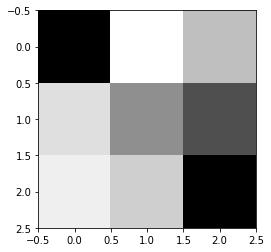

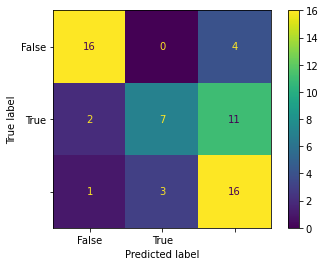

[[7. 7. 6.]
 [6. 7. 7.]
 [7. 6. 7.]]


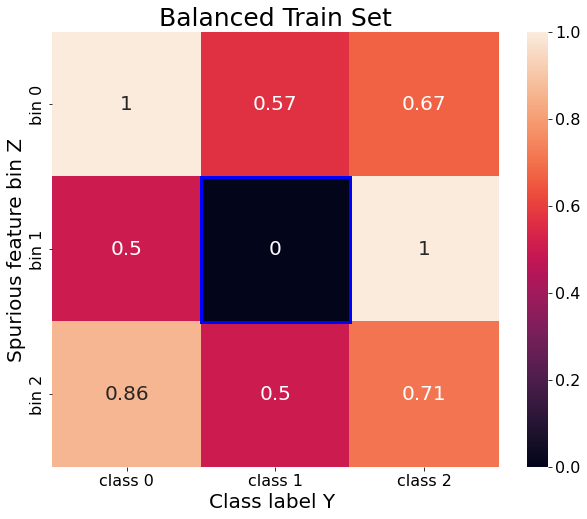

0.65

In [ ]:
evaluate_dataset(df_balanced_train, df_balanced_test, stylized_dataset, title = "Balanced Train Set")

In [ ]:
df_train

,FILE_NAME,CATEGORY,SUPER_CATEGORY,Label
174,65771.jpg,horse racing,NaN,0
799,169057.jpg,horse racing,NaN,0
277,40240.jpg,horse racing,NaN,0
7,18563.jpg,horse racing,NaN,0
100,57291.jpg,horse racing,NaN,0
645,49921.jpg,horse racing,NaN,0
391,96655.jpg,horse racing,NaN,0
299,129388.jpg,horse racing,NaN,0
272,191300.jpg,horse racing,NaN,0
429,184076.jpg,horse racing,NaN,0
